In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

# My commonly used R imports

require('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse


In [4]:
## SET UP \

In [5]:
%%R
# Load packages and prepare environment
library(tidyverse)
library(fixest)
library(ggplot2)


In [6]:
%%R
# Load the dataset
df <- read_csv("merged_hmda_with_demo.csv")

# Create binary outcome


Rows: 148917888 Columns: 28
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): lei, state_code, county_code, derived_dwelling_category, property_...
dbl (23): activity_year, action_taken, loan_purpose, lien_status, loan_amoun...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
%%R
df <- df %>%
  mutate(
    approved = ifelse(action_taken == 1, 1, 0),
    county_code = as.character(as.integer(as.numeric(county_code)))
  )

In addition: Warning message:
There was 1 warning in `mutate()`.
ℹ In argument: `county_code =
  as.character(as.integer(as.numeric(county_code)))`.
Caused by warning:
! NAs introduced by coercion 


In [ ]:
%%R
df_clean <- df %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    post_dei_law = ifelse(activity_year >= 2022, 1, 0),
    anti_dei_state = ifelse(state_code %in% c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH"), 1, 0),
    race = case_when(
      `applicant_race-1` == 3 ~ "Black",
      `applicant_race-1` == 1 ~ "White",
      TRUE ~ NA_character_
    ),
    debt_to_income = loan_amount / income
  ) %>%
  filter(!is.na(race), is.finite(debt_to_income))


In [12]:
%%R
approval_summary <- df_processed %>%
  group_by(county_code, activity_year, lei, post_dei, race, dei_state) %>%
  summarise(
    mean_approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )


In [64]:
%%R
choropleth_data <- df_clean %>%
  filter(race == "Black", post_dei_law == 1) %>%
  group_by(state_code) %>%
  summarise(approval_rate = mean(approved, na.rm = TRUE))


In [65]:
%%R
us_states <- map_data("state")


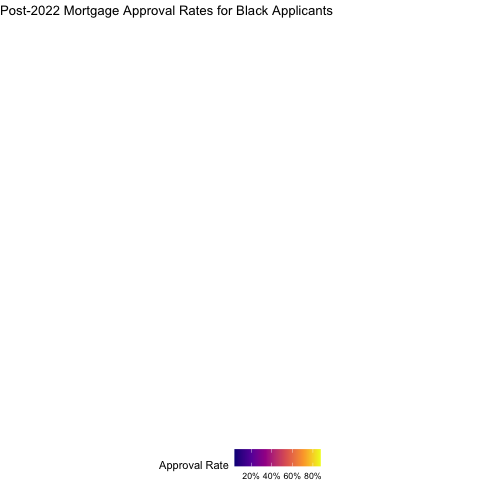

In [66]:
%%R
choropleth_data <- choropleth_data %>%
  mutate(state_name = tolower(state_code)) %>%
  left_join(us_states, by = c("state_name" = "region"))

ggplot(choropleth_data, aes(long, lat, group = group, fill = approval_rate)) +
  geom_polygon(color = "white") +
  scale_fill_viridis_c(option = "plasma", labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Post-2022 Mortgage Approval Rates for Black Applicants",
    fill = "Approval Rate"
  ) +
  theme_void() +
  theme(legend.position = "bottom")


In [67]:
%%R
model <- lm(approved ~ post_dei_law * race, data = df_clean)
summary(model)



Call:
lm(formula = approved ~ post_dei_law * race, data = df_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5548 -0.5548  0.4452  0.4452  0.5147 

Coefficients:
                         Estimate Std. Error  t value Pr(>|t|)    
(Intercept)             0.5548301  0.0001898 2922.990  < 2e-16 ***
post_dei_law           -0.0592109  0.0003840 -154.183  < 2e-16 ***
raceWhite              -0.0018446  0.0005945   -3.103  0.00192 ** 
post_dei_law:raceWhite -0.0084874  0.0012048   -7.045 1.86e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4977 on 10130218 degrees of freedom
Multiple R-squared:  0.002692,	Adjusted R-squared:  0.002692 
F-statistic:  9114 on 3 and 10130218 DF,  p-value: < 2.2e-16



In [11]:
%%R
library(dplyr)
library(ggplot2)

# Step 1: Clean and mutate
df_processed <- df %>%
  filter(!is.na(`applicant_race-1`), income > 0) %>% 
  mutate(
    race = case_when(
      `applicant_race-1` == 3 ~ "Black",
      `applicant_race-1` == 1 ~ "White",
      TRUE ~ NA_character_
    ),
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0), 
    post_dei_law = ifelse(activity_year >= 2022, 1, 0),
    anti_dei_state = ifelse(state_code %in% c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH"), 1, 0),
    black_applicant = ifelse(`applicant_race-1` == 3, 1, 0),
    debt_to_income = loan_amount / income,
    dei_state = ifelse(anti_dei_state == 1, "Anti-DEI State", "Other State"),
    post_dei = ifelse(post_dei_law == 1, "Post-DEI Law", "Pre-DEI Law")
  ) %>%
  filter(!is.na(race), is.finite(debt_to_income))  

# Step 2: Group and summarize by county_code, activity_year, and lei
approval_summary <- df_processed %>%
  group_by(county_code, activity_year, lei, post_dei, race, dei_state) %>%
  summarise(
    mean_approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )


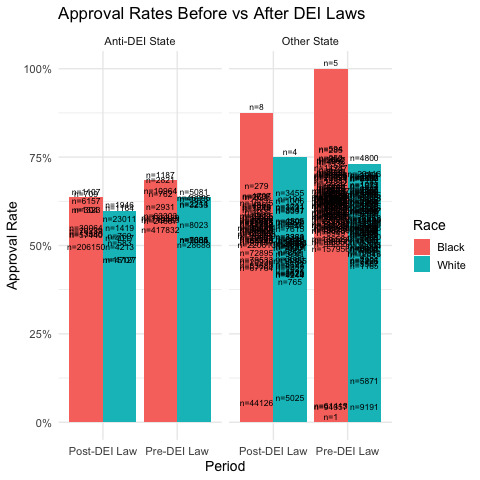

In [41]:
%%R
ggplot(approval_summary, aes(x = post_dei, y = mean_approval_rate, fill = race, group = race)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.9)) +
  geom_text(
    aes(label = paste0("n=", n)),
    position = position_dodge(width = 0.9),
    vjust = -0.5,
    size = 3
  ) +
  facet_wrap(~dei_state) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1), limits = c(0, 1)) +
  labs(
    title = "Approval Rates Before vs After DEI Laws",
    x = "Period",
    y = "Approval Rate",
    fill = "Race"
  ) +
  theme_minimal(base_size = 14)


In [42]:
%%R
approval_summary <- df_processed %>%
  group_by(state_code, post_dei, race, dei_state) %>%
  summarise(
    mean_approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )


In [43]:
%%R
library(dplyr)

choropleth_data <- df_clean %>%
  filter(post_dei_law == 1, race %in% c("Black", "White")) %>%
  group_by(state_code, race) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )


In [44]:
%%R
approval_summary <- df_clean %>%
  group_by(state_code, post_dei, race, dei_state) %>%
  summarise(
    mean_approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )

In [48]:
%%R
state_lookup <- data.frame(
  state_code = state.abb,
  state_name = state.name,
  stringsAsFactors = FALSE
)


In [49]:
%%R
choropleth_split <- df_clean %>%
  filter(race == "Black") %>%
  mutate(period = ifelse(post_dei_law == 1, "Post-2022", "Pre-2022")) %>%
  group_by(state_code, period) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  left_join(state_lookup, by = "state_code")  # Add state_name


In [50]:
%%R 
library(dplyr)
library(tibble)
library(ggplot2)
library(viridis)
library(maps)

# Get lowercase state names
state_lookup <- tibble(
  state_code = state.abb,
  state_name = tolower(state.name)
)

# Create approval rate by state + period
choropleth_data <- df_clean %>%
  filter(race == "Black") %>%
  mutate(
    period = ifelse(post_dei_law == 1, "Post-2022", "Pre-2022")
  ) %>%
  group_by(state_code, period) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  left_join(state_lookup, by = "state_code") %>%
  filter(!is.na(state_name))  # Drop DC, PR, etc. not in map_data


Loading required package: viridisLite

Attaching package: ‘maps’

The following object is masked from ‘package:viridis’:

    unemp

The following object is masked from ‘package:purrr’:

    map



Error in `geom_line()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! object 'activity_year' not found
Run `rlang::last_trace()` to see where the error occurred.


In addition: Warning messages:
1: Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
2: Unknown or uninitialised column: `activity_year`. 


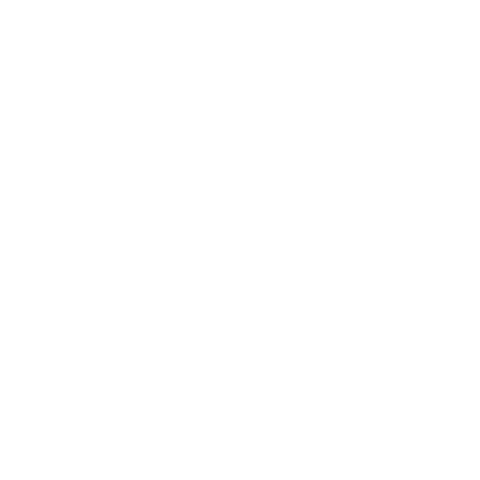

RRuntimeError: Error in geom_line(size = 1.2) : 
ℹ Error occurred in the 1st layer.
Caused by error:
! object 'activity_year' not found


In [51]:
%%R
ggplot(approval_summary, aes(x = activity_year, y = mean_approval_rate,
                              color = race, linetype = dei_state)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  scale_x_continuous(breaks = unique(approval_summary$activity_year)) +
  labs(
    title = "Mortgage Approval Rates Over Time",
    subtitle = "Split by Race and Anti-DEI State Status",
    x = "Year",
    y = "Approval Rate",
    color = "Applicant Race",
    linetype = "State Type"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(face = "bold")
  )


In [52]:
%%R
choropleth_data <- df_clean %>%
  filter(post_dei_law == 1, race %in% c("Black", "White")) %>%
  group_by(state_code, race) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  ) %>%
  left_join(state_lookup, by = "state_code")  # Add lowercase `state_name`


In [53]:
%%R
# Define the list of anti-DEI states
anti_dei_states <- c("AL", "AR", "FL", "ID", "IN", "NC", "ND", "TN", "TX", "UT", "WY")

# Add a column to indicate whether each state is an anti-DEI state
df_clean <- df_clean %>%
  mutate(
    anti_dei_state = ifelse(state_code %in% anti_dei_states, 1, 0),
    state_label = ifelse(anti_dei_state == 1, state_code, paste0(state_code, " (Other)"))
  )


In [54]:
%%R
approval_summary <- df_clean %>%
  group_by(activity_year, state_code, race, anti_dei_state) %>%
  summarise(
    mean_approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  ) %>%
  mutate(
    state_label = ifelse(anti_dei_state == 1, state_code, paste0(state_code, " (Other)"))
  )


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


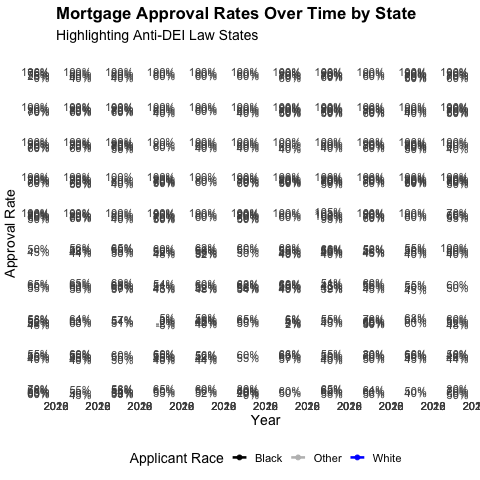

In [55]:
%%R
library(ggplot2)

ggplot(approval_summary, aes(x = activity_year, y = mean_approval_rate, group = race)) +
  geom_line(aes(color = ifelse(anti_dei_state == 1, race, "Other")), size = 1.2) +
  geom_point(aes(color = ifelse(anti_dei_state == 1, race, "Other")), size = 2) +
  scale_color_manual(
    values = c("Black" = "black", "White" = "blue", "Other" = "gray"),
    name = "Applicant Race"
  ) +
  facet_wrap(~ state_label, scales = "free_y") +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Mortgage Approval Rates Over Time by State",
    subtitle = "Highlighting Anti-DEI Law States",
    x = "Year",
    y = "Approval Rate"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(face = "bold")
  )


In [32]:
%%R
approval_summary <- df_processed %>%
  group_by(state_code, post_dei, race, dei_state) %>%
  summarise(
    mean_approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )


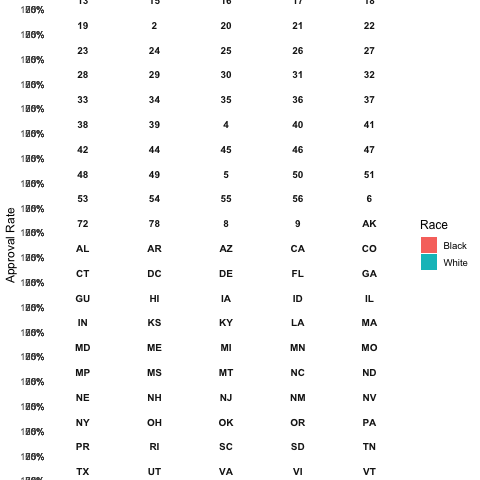

In [33]:
%%R
ggplot(approval_summary, aes(x = post_dei, y = mean_approval_rate, fill = race)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ state_code, ncol = 5) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Approval Rates by State: Pre vs Post DEI Law",
    x = "Period",
    y = "Approval Rate",
    fill = "Race"
  ) +
  theme_minimal(base_size = 12) +
  theme(strip.text = element_text(face = "bold", size = 10))


In [ ]:
%%R
library(dplyr)

choropleth_data <- df_clean %>%
  filter(post_dei_law == 1, race %in% c("Black", "White")) %>%
  group_by(state_code, race) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )


In [ ]:
%%R
us_states <- map_data("state")


In [ ]:
%%R
approval_summary <- df_clean %>%
  group_by(state_code, post_dei, race, dei_state) %>%
  summarise(
    mean_approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )


In [10]:
%%R
approval_summary <- df_clean %>%
  group_by(state_code, post_dei, race, dei_state) %>%
  summarise(
    mean_approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )
approval_summary.head(20)

Error in `summarise()`:
ℹ In argument: `mean_approval_rate = mean(approved, na.rm = TRUE)`.
ℹ In group 1: `state_code = "0"`, `post_dei = "Pre-DEI Law"`, `race = "Black"`,
  `dei_state = "Other State"`.
Caused by error:
! object 'approved' not found
Run `rlang::last_trace()` to see where the error occurred.

Error in summarise(., mean_approval_rate = mean(approved, na.rm = TRUE),  : 
  
ℹ In group 1: `state_code = "0"`, `post_dei = "Pre-DEI Law"`, `race = "Black"`,
  `dei_state = "Other State"`.
Caused by error:
! object 'approved' not found


RInterpreterError: Failed to parse and evaluate line 'approval_summary <- df_clean %>%\n  group_by(state_code, post_dei, race, dei_state) %>%\n  summarise(\n    mean_approval_rate = mean(approved, na.rm = TRUE),\n    n = n(),\n    .groups = "drop"\n  )\napproval_summary.head(20)\n'.
R error message: 'Error in summarise(., mean_approval_rate = mean(approved, na.rm = TRUE),  : \n  \nℹ In group 1: `state_code = "0"`, `post_dei = "Pre-DEI Law"`, `race = "Black"`,\n  `dei_state = "Other State"`.\nCaused by error:\n! object \'approved\' not found'

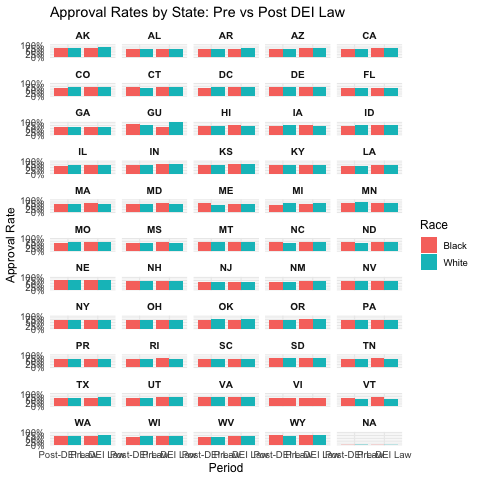

In [110]:
%%R
ggplot(approval_summary, aes(x = post_dei, y = mean_approval_rate, fill = race)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ state_code, ncol = 5) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Approval Rates by State: Pre vs Post DEI Law",
    x = "Period",
    y = "Approval Rate",
    fill = "Race"
  ) +
  theme_minimal(base_size = 12) +
  theme(strip.text = element_text(face = "bold", size = 10))


In [111]:
%%R
df_clean %>%
  filter(state_code == "VI") %>%
  count(post_dei, race)


# A tibble: 2 × 3
  post_dei     race      n
  <chr>        <chr> <int>
1 Post-DEI Law Black    15
2 Pre-DEI Law  Black    38


In [112]:
%%R
library(dplyr)

choropleth_data <- df_clean %>%
  filter(post_dei_law == 1, race %in% c("Black", "White")) %>%
  group_by(state_code, race) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )


In [36]:
# %%R
# us_states <- map_data("state")


In addition: Warning message:
In geom_map(data = us_states, map = us_states, aes(x = long, y = lat,  :
  Ignoring unknown aesthetics: x and y


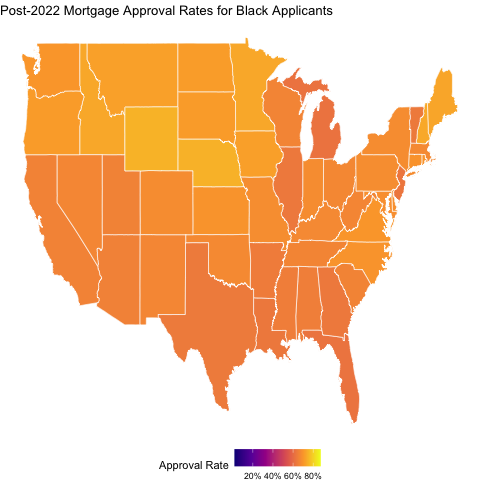

In [119]:
%%R
choropleth_black <- choropleth_data %>%
  filter(race == "Black")

ggplot() +
  geom_map(data = us_states, map = us_states,
           aes(x = long, y = lat, map_id = region),
           fill = "gray95", color = "white") +
  geom_map(data = choropleth_black, map = us_states,
           aes(map_id = state_name, fill = approval_rate),
           color = "white", size = 0.3) +
  scale_fill_viridis_c(option = "plasma", labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Post-2022 Mortgage Approval Rates for Black Applicants",
    fill = "Approval Rate"
  ) +
  theme_void() +
  theme(legend.position = "bottom")


In [120]:
%%R
choropleth_split <- df_clean %>%
  filter(race == "Black") %>%
  mutate(period = ifelse(post_dei_law == 1, "Post-2022", "Pre-2022")) %>%
  group_by(state_code, period) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  left_join(state_lookup, by = "state_code")  # Add state_name


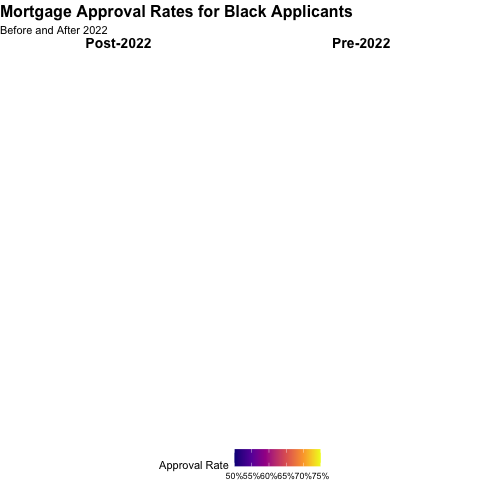

In [121]:
%%R
ggplot() +
  geom_map(data = us_states, map = us_states,
           aes(map_id = region),
           fill = "gray95", color = "white") +
  geom_map(data = choropleth_split, map = us_states,
           aes(map_id = state_name, fill = approval_rate),
           color = "white", size = 0.3) +
  facet_wrap(~period) +
  scale_fill_viridis_c(
    option = "plasma",
    labels = scales::percent_format(accuracy = 1),
    limits = c(0.5, 0.75)  # Adjust this to exaggerate contrast
  ) +
  labs(
    title = "Mortgage Approval Rates for Black Applicants",
    subtitle = "Before and After 2022",
    fill = "Approval Rate"
  ) +
  theme_void() +
  theme(
    legend.position = "bottom",
    strip.text = element_text(face = "bold", size = 14),
    plot.title = element_text(face = "bold", size = 16)
  )


In [126]:
%%R 
library(dplyr)
library(tibble)
library(ggplot2)
library(viridis)
library(maps)

# Get lowercase state names
state_lookup <- tibble(
  state_code = state.abb,
  state_name = tolower(state.name)
)

# Create approval rate by state + period
choropleth_data <- df_clean %>%
  filter(race == "Black") %>%
  mutate(
    period = ifelse(post_dei_law == 1, "Post-2022", "Pre-2022")
  ) %>%
  group_by(state_code, period) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  left_join(state_lookup, by = "state_code") %>%
  filter(!is.na(state_name))  # Drop DC, PR, etc. not in map_data


Loading required package: viridisLite

Attaching package: ‘maps’

The following object is masked from ‘package:viridis’:

    unemp

The following object is masked from ‘package:purrr’:

    map



In [127]:
%%R
us_states <- map_data("state")

# Join map with approval rates
choropleth_plot_data <- left_join(us_states, choropleth_data, by = c("region" = "state_name"))



In addition: Warning message:
In left_join(us_states, choropleth_data, by = c(region = "state_name")) :
  Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 3 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.


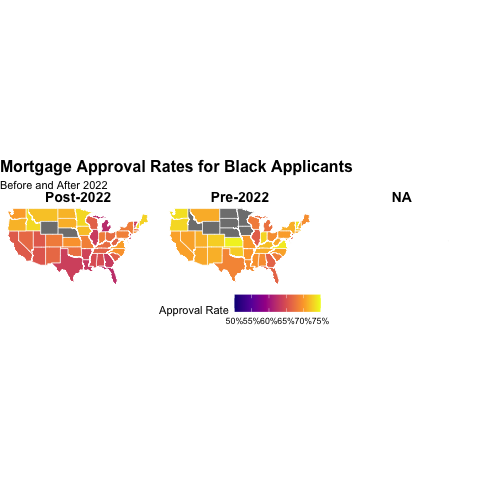

In [128]:
%%R
ggplot(choropleth_plot_data, aes(x = long, y = lat, group = group, fill = approval_rate)) +
  geom_polygon(color = "white", size = 0.3) +
  coord_fixed(1.3) +
  facet_wrap(~period) +
  scale_fill_viridis_c(
    option = "plasma",
    labels = scales::percent_format(accuracy = 1),
    limits = c(0.5, 0.75)
  ) +
  labs(
    title = "Mortgage Approval Rates for Black Applicants",
    subtitle = "Before and After 2022",
    fill = "Approval Rate"
  ) +
  theme_void() +
  theme(
    legend.position = "bottom",
    strip.text = element_text(face = "bold", size = 14),
    plot.title = element_text(face = "bold", size = 16)
  )


In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


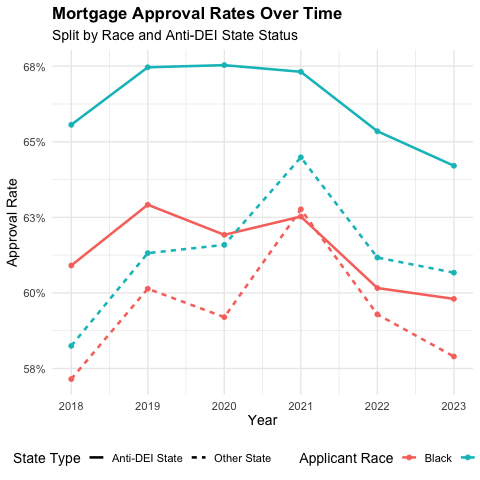

In [73]:
%%R
ggplot(approval_summary, aes(x = activity_year, y = mean_approval_rate,
                              color = race, linetype = dei_state)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  scale_x_continuous(breaks = unique(approval_summary$activity_year)) +
  labs(
    title = "Mortgage Approval Rates Over Time",
    subtitle = "Split by Race and Anti-DEI State Status",
    x = "Year",
    y = "Approval Rate",
    color = "Applicant Race",
    linetype = "State Type"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(face = "bold")
  )


In [115]:
%%R
state_lookup <- tibble::tibble(
  state_code = c(state.abb, "DC"),
  state_name = tolower(c(state.name, "District of Columbia"))
)


In [116]:
%%R
choropleth_data <- df_clean %>%
  filter(post_dei_law == 1, race %in% c("Black", "White")) %>%
  group_by(state_code, race) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  ) %>%
  left_join(state_lookup, by = "state_code")  # Add lowercase `state_name`


In [117]:
%%R
choropleth_black <- choropleth_data %>%
  filter(race == "Black")


In [118]:
%%R
us_states <- map_data("state")


In [74]:
%%R
# Define the list of anti-DEI states
anti_dei_states <- c("AL", "AR", "FL", "ID", "IN", "NC", "ND", "TN", "TX", "UT", "WY")

# Add a column to indicate whether each state is an anti-DEI state
df_clean <- df_clean %>%
  mutate(
    anti_dei_state = ifelse(state_code %in% anti_dei_states, 1, 0),
    state_label = ifelse(anti_dei_state == 1, state_code, paste0(state_code, " (Other)"))
  )


In [75]:
%%R
approval_summary <- df_clean %>%
  group_by(activity_year, state_code, race, anti_dei_state) %>%
  summarise(
    mean_approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  ) %>%
  mutate(
    state_label = ifelse(anti_dei_state == 1, state_code, paste0(state_code, " (Other)"))
  )


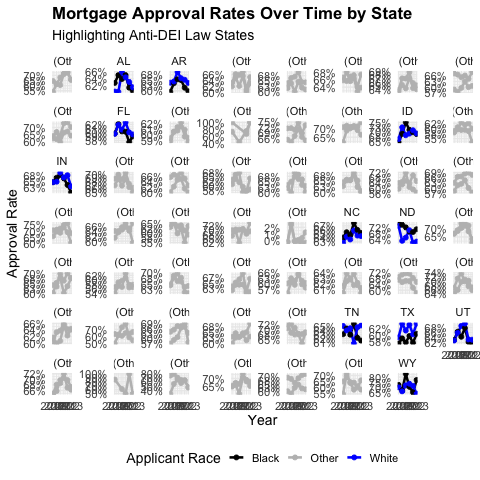

In [76]:
%%R
library(ggplot2)

ggplot(approval_summary, aes(x = activity_year, y = mean_approval_rate, group = race)) +
  geom_line(aes(color = ifelse(anti_dei_state == 1, race, "Other")), size = 1.2) +
  geom_point(aes(color = ifelse(anti_dei_state == 1, race, "Other")), size = 2) +
  scale_color_manual(
    values = c("Black" = "black", "White" = "blue", "Other" = "gray"),
    name = "Applicant Race"
  ) +
  facet_wrap(~ state_label, scales = "free_y") +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Mortgage Approval Rates Over Time by State",
    subtitle = "Highlighting Anti-DEI Law States",
    x = "Year",
    y = "Approval Rate"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(face = "bold")
  )


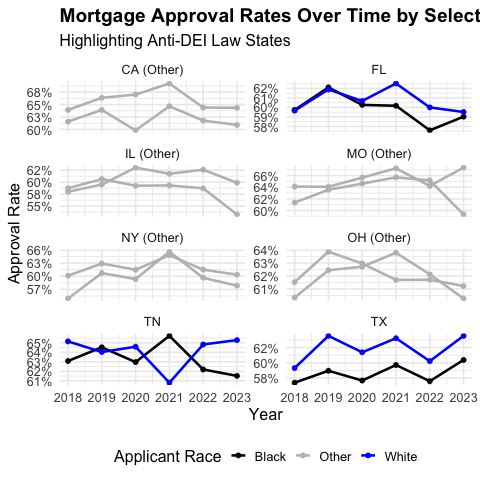

In [77]:
%%R
selected_states <- c("FL", "TX", "CA", "NY", "OH", "TN", "MO", "IL")

approval_summary_subset <- approval_summary %>%
  filter(state_code %in% selected_states)

ggplot(approval_summary_subset, aes(x = activity_year, y = mean_approval_rate, group = race)) +
  geom_line(aes(color = ifelse(anti_dei_state == 1, race, "Other")), size = 1.2) +
  geom_point(aes(color = ifelse(anti_dei_state == 1, race, "Other")), size = 2) +
  scale_color_manual(
    values = c("Black" = "black", "White" = "blue", "Other" = "gray"),
    name = "Applicant Race"
  ) +
  facet_wrap(~ state_label, ncol = 2, scales = "free_y") +  # Fewer columns = bigger plots
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Mortgage Approval Rates Over Time by Selected States",
    subtitle = "Highlighting Anti-DEI Law States",
    x = "Year",
    y = "Approval Rate"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(face = "bold")
  )


In [78]:
%%R
df_clean <- df_clean %>%
  mutate(
    post_georgefloyd = ifelse(activity_year >= 2020, 1, 0)
  )


In [80]:
%%R
model_simple <- lm(approved ~ post_georgefloyd, data = df_clean)
summary(model_simple)



Call:
lm(formula = approved ~ post_georgefloyd, data = df_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6044 -0.6044  0.3956  0.3956  0.4060 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.5939856  0.0004871 1219.51   <2e-16 ***
post_georgefloyd 0.0104184  0.0005834   17.86   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4896 on 3334238 degrees of freedom
Multiple R-squared:  9.563e-05,	Adjusted R-squared:  9.533e-05 
F-statistic: 318.9 on 1 and 3334238 DF,  p-value: < 2.2e-16



In [81]:
%%R
fe_model_floyd <- feols(
  approved ~ post_georgefloyd | county_code + lei,
  data = df_clean
)

summary(fe_model_floyd)


OLS estimation, Dep. Var.: approved
Observations: 3,173,851
Fixed-effects: county_code: 3,139,  lei: 4,992
Standard-errors: Clustered (county_code) 
                  Estimate Std. Error  t value  Pr(>|t|)    
post_georgefloyd -0.012939   0.001215 -10.6531 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.463471     Adj. R2: 0.075297
                 Within R2: 1.493e-4


NOTE: 160,389 observations removed because of NA values (Fixed-effects: 160,389).


In [82]:
%%R
# Filter for Black applicants
df_black <- df_clean %>% filter(`applicant_race-1` == 3)

# Filter for White applicants
df_white <- df_clean %>% filter(`applicant_race-1` == 1)


In [83]:
%%R
# Model for Black applicants
model_black <- lm(approved ~ post_georgefloyd, data = df_black)
summary(model_black)


Call:
lm(formula = approved ~ post_georgefloyd, data = df_black)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6019 -0.6019  0.3981  0.3981  0.4078 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.5922329  0.0005086  1164.5   <2e-16 ***
post_georgefloyd 0.0096380  0.0006099    15.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4901 on 3047076 degrees of freedom
Multiple R-squared:  8.194e-05,	Adjusted R-squared:  8.161e-05 
F-statistic: 249.7 on 1 and 3047076 DF,  p-value: < 2.2e-16



In [84]:
%%R

# Model for White applicants
model_white <- lm(approved ~ post_georgefloyd, data = df_white)
summary(model_white)



Call:
lm(formula = approved ~ post_georgefloyd, data = df_white)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6305 -0.6305  0.3695  0.3695  0.3861 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.613872   0.001691 362.957   <2e-16 ***
post_georgefloyd 0.016668   0.002000   8.333   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4839 on 287160 degrees of freedom
Multiple R-squared:  0.0002418,	Adjusted R-squared:  0.0002383 
F-statistic: 69.44 on 1 and 287160 DF,  p-value: < 2.2e-16



In [88]:
%%R
did_model <- lm(approved ~ post_georgefloyd * black_applicant, data = df_clean)
summary(did_model)



Call:
lm(formula = approved ~ post_georgefloyd * black_applicant, data = df_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6305 -0.6019  0.3981  0.3981  0.4078 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.613872   0.001711 358.732  < 2e-16 ***
post_georgefloyd                  0.016668   0.002024   8.236  < 2e-16 ***
black_applicant                  -0.021640   0.001785 -12.123  < 2e-16 ***
post_georgefloyd:black_applicant -0.007030   0.002113  -3.326  0.00088 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4896 on 3334236 degrees of freedom
Multiple R-squared:  0.0003321,	Adjusted R-squared:  0.0003312 
F-statistic: 369.3 on 3 and 3334236 DF,  p-value: < 2.2e-16



In [91]:
%%R
df_multigroup <- df_multigroup %>%
  mutate(race_group = factor(race_group, levels = c("White", "Black", "Asian", "Native", "Other")))


In [92]:
%%R
model_multigroup <- lm(approved ~ post_georgefloyd * race_group, data = df_multigroup)
summary(model_multigroup)



Call:
lm(formula = approved ~ post_georgefloyd * race_group, data = df_multigroup)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6305 -0.6019  0.3981  0.3981  0.4078 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.613872   0.001711 358.732  < 2e-16 ***
post_georgefloyd                  0.016668   0.002024   8.236  < 2e-16 ***
race_groupBlack                  -0.021640   0.001785 -12.123  < 2e-16 ***
post_georgefloyd:race_groupBlack -0.007030   0.002113  -3.326  0.00088 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4896 on 3334236 degrees of freedom
Multiple R-squared:  0.0003321,	Adjusted R-squared:  0.0003312 
F-statistic: 369.3 on 3 and 3334236 DF,  p-value: < 2.2e-16



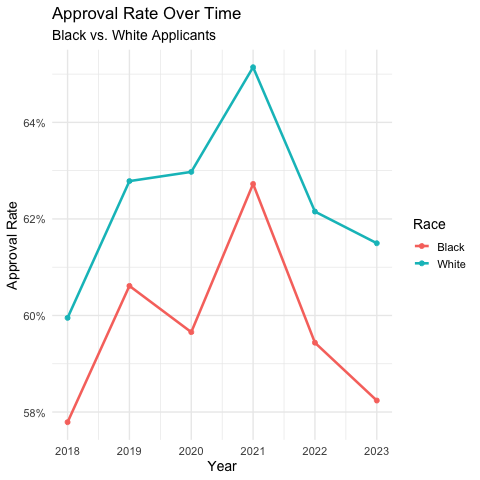

In [98]:
%%R
library(dplyr)
library(ggplot2)

df_summary <- df_clean %>%
  filter(`applicant_race-1` %in% c(1, 3)) %>%  # White = 1, Black = 3
  mutate(
    race = ifelse(`applicant_race-1` == 3, "Black", "White")
  ) %>%
  group_by(activity_year, race) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )

ggplot(df_summary, aes(x = activity_year, y = approval_rate, color = race)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Approval Rate Over Time",
    subtitle = "Black vs. White Applicants",
    x = "Year",
    y = "Approval Rate",
    color = "Race"
  ) +
  theme_minimal(base_size = 14)



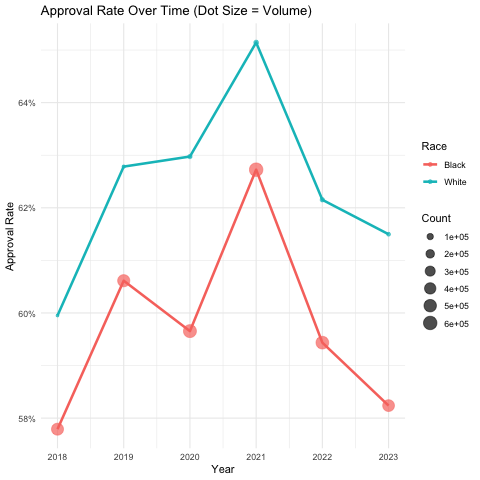

In [100]:
%%R
df_summary <- df_clean %>%
  filter(`applicant_race-1` %in% c(1, 3)) %>%
  mutate(race = ifelse(`applicant_race-1` == 3, "Black", "White")) %>%
  group_by(activity_year, race) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )

ggplot(df_summary, aes(x = activity_year, y = approval_rate, color = race)) +
  geom_line(size = 1.2) +
  geom_point(aes(size = n), alpha = 0.7) +  # Add dot size by count
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Approval Rate Over Time (Dot Size = Volume)",
    x = "Year", y = "Approval Rate", color = "Race", size = "Count"
  ) +
  theme_minimal()


In [90]:
%%R
df_multigroup <- df_clean %>%
  mutate(
    race_group = case_when(
      `applicant_race-1` == 1 ~ "White",
      `applicant_race-1` == 2 ~ "Asian",
      `applicant_race-1` == 3 ~ "Black",
      `applicant_race-1` == 4 ~ "Native",
      `applicant_race-1` == 5 ~ "Other"
    ),
    post_georgefloyd = ifelse(activity_year >= 2020, 1, 0)
  ) %>%
  filter(!is.na(race_group))

model_multigroup <- lm(approved ~ post_georgefloyd * race_group, data = df_multigroup)
summary(model_multigroup)



Call:
lm(formula = approved ~ post_georgefloyd * race_group, data = df_multigroup)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6305 -0.6019  0.3981  0.3981  0.4078 

Coefficients:
                                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                      0.5922329  0.0005080 1165.770  < 2e-16 ***
post_georgefloyd                 0.0096380  0.0006093   15.819  < 2e-16 ***
race_groupWhite                  0.0216395  0.0017850   12.123  < 2e-16 ***
post_georgefloyd:race_groupWhite 0.0070299  0.0021135    3.326  0.00088 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4896 on 3334236 degrees of freedom
Multiple R-squared:  0.0003321,	Adjusted R-squared:  0.0003312 
F-statistic: 369.3 on 3 and 3334236 DF,  p-value: < 2.2e-16



In [58]:
%%R
fe_model_black <- feols(
  approved ~ post_georgefloyd + employment_rate | county_code + activity_year + lei,
  data = df_clean %>% filter(black_applicant == 1)
)


Error in feols(approved ~ post_georgefloyd + employment_rate | county_code +  : 
  The variable 'post_georgefloyd' is in the RHS (first part) of the formula
but not in the data set.


RInterpreterError: Failed to parse and evaluate line 'fe_model_black <- feols(\n  approved ~ post_georgefloyd + employment_rate | county_code + activity_year + lei,\n  data = df_clean %>% filter(black_applicant == 1)\n)\n'.
R error message: "Error in feols(approved ~ post_georgefloyd + employment_rate | county_code +  : \n  The variable 'post_georgefloyd' is in the RHS (first part) of the formula\nbut not in the data set."

In [9]:
%%R
##Use black applicant number and loan level instead of county % 
library(fixest)

fe_model <- feols(
  approved ~ post_georgefloyd * black_applicant + employment_rate | county_code + activity_year + lei,
  data = df_clean
)

summary(fe_model)
#Before 2020, Black applicants were 4.5 percentage points less likely to be approved compared to non-Black applicants, After 2020, the racial approval gap for Black applicants narrowed slightly by 0.6 points

OLS estimation, Dep. Var.: approved
Observations: 38,440,120
Fixed-effects: county_code: 3,220,  activity_year: 6,  lei: 6,078
Standard-errors: Clustered (county_code) 
                                  Estimate  Std. Error    t value  Pr(>|t|)    
black_applicant                  -0.021069    0.002365  -8.910431 < 2.2e-16 ***
employment_rate                   5.188143 6787.668722   0.000764   0.99939    
post_georgefloyd:black_applicant -0.015082    0.001303 -11.573227 < 2.2e-16 ***
... 1 variable was removed because of collinearity (post_georgefloyd)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.431704     Adj. R2: 0.224496
                 Within R2: 3.569e-4


NOTE: 1,309,496 observations removed because of NA values (RHS: 1,309,496, Fixed-effects: 1,303,980).
The variable 'post_georgefloyd' has been removed because of collinearity (see $collin.var).


In [ ]:
%%R
##Use black applicant number and loan level instead of county % 
library(fixest)

fe_model <- feols(
  approved ~ post_georgefloyd * black_applicant + black_applicant + post_georgefloyd + employment_rate | county_code + activity_year + lei,
  data = df_clean
)

summary(fe_model)
#Before 2020, Black applicants were 4.5 percentage points less likely to be approved compared to non-Black applicants, After 2020, the racial approval gap for Black applicants narrowed slightly by 0.6 points

In [28]:
%%R
summary(fe_model)


GLM estimation, family = binomial(link = "logit"), Dep. Var.: approved
Observations: 33,562,649
Fixed-effects: county_code: 3,224,  activity_year: 6,  lei: 5,696
Standard-errors: Clustered (county_code) 
                                                Estimate   Std. Error
anti_dei_state                               0.879585666 0.0981754538
black_applicant                             -0.304335051 0.0112809252
income                                      -0.000031947 0.0000058244
loan_amount                                  0.000000237 0.0000000149
debt_to_income                              -0.000052195 0.0000018966
post_dei_law:anti_dei_state                 -0.015215778 0.0095748756
post_dei_law:black_applicant                 0.000325206 0.0062248482
anti_dei_state:black_applicant               0.028073042 0.0200215079
post_dei_law:anti_dei_state:black_applicant -0.025587222 0.0148626916
                                               z value   Pr(>|z|)    
anti_dei_state            

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: The GLM algorithm did not converge, the results are not reliable. (no convergence: Maximum number of iterations reached) 



## control for income, DTI + loan amount 
income, loan_amount, and debt_to_income may not vary much within each fixed effect group, especially at the bank level, so adding these make R-squared lowered a lot 

In [10]:
%%R
library(fixest)

# Add debt-to-income ratio (loan amount ÷ income)
df_clean <- df_clean %>%
  mutate(
    debt_to_income = loan_amount / income
  ) %>%
  filter(
    !is.na(income), income > 0,
    !is.na(loan_amount), loan_amount > 0,
    !is.na(debt_to_income), is.finite(debt_to_income)
  )

# Run the fixed-effects model with financial controls
fe_model_controls <- feols(
  approved ~ post_georgefloyd * black_applicant + income + loan_amount + debt_to_income + employment_rate |
    county_code + activity_year + lei,
  data = df_clean
)

# View results
summary(fe_model_controls)


OLS estimation, Dep. Var.: approved
Observations: 33,578,289
Fixed-effects: county_code: 3,219,  activity_year: 6,  lei: 6,039
Standard-errors: Clustered (county_code) 
                                      Estimate   Std. Error    t value
black_applicant                  -5.813126e-02 2.015332e-03 -28.844507
income                           -1.333100e-08 8.524000e-09  -1.563917
loan_amount                       8.780000e-10 8.640000e-10   1.015346
debt_to_income                   -4.865700e-08 4.753700e-08  -1.023563
employment_rate                   2.654824e+01 6.036324e+03   0.004398
post_georgefloyd:black_applicant -8.688125e-03 1.218649e-03  -7.129308
                                   Pr(>|t|)    
black_applicant                   < 2.2e-16 ***
income                           1.1794e-01    
loan_amount                      3.1002e-01    
debt_to_income                   3.0612e-01    
employment_rate                  9.9649e-01    
post_georgefloyd:black_applicant 1.2400e-12 **

NOTE: 1,194,235 observations removed because of NA values (RHS: 1,194,235, Fixed-effects: 1,188,844).
The variable 'post_georgefloyd' has been removed because of collinearity (see $collin.var).


In [ ]:
%%R
library(fixest)

# Add debt-to-income ratio (loan amount ÷ income)
df_clean <- df_clean %>%
  mutate(
    debt_to_income = loan_amount / income
  ) %>%
  filter(
    !is.na(income), income > 0,
    !is.na(loan_amount), loan_amount > 0,
    !is.na(debt_to_income), is.finite(debt_to_income)
  )

# Run the fixed-effects model with financial controls
fe_model_controls <- feols(
  approved ~ post_georgefloyd * black_applicant + income + loan_amount + debt_to_income + employment_rate |
    county_code * activity_year + lei * county_code,
  data = df_clean
)
## bank county, groupby county year
# View results
summary(fe_model_controls)


`geom_smooth()` using formula = 'y ~ x'


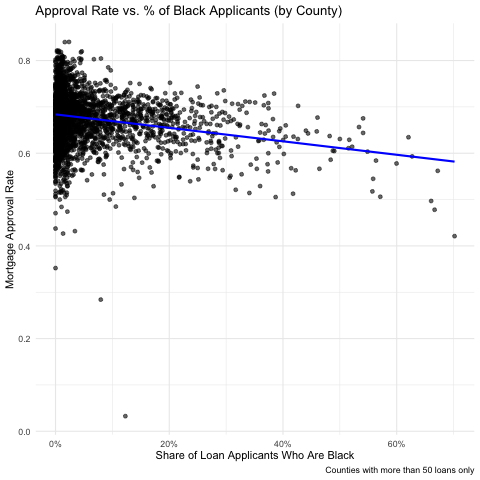

In [11]:
%%R
library(dplyr)
library(ggplot2)

county_plot_df <- df_clean %>%
  filter(!is.na(approved), !is.na(black_applicant)) %>%
  group_by(county_code) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    pct_black_applicants = mean(black_applicant, na.rm = TRUE),
    total_loans = n()
  ) %>%
  filter(total_loans > 50)

ggplot(county_plot_df, aes(x = pct_black_applicants, y = approval_rate)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", color = "blue", se = FALSE) +
  scale_x_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Approval Rate vs. % of Black Applicants (by County)",
    x = "Share of Loan Applicants Who Are Black",
    y = "Mortgage Approval Rate",
    caption = "Counties with more than 50 loans only"
  ) +
  theme_minimal()


`geom_smooth()` using formula = 'y ~ x'


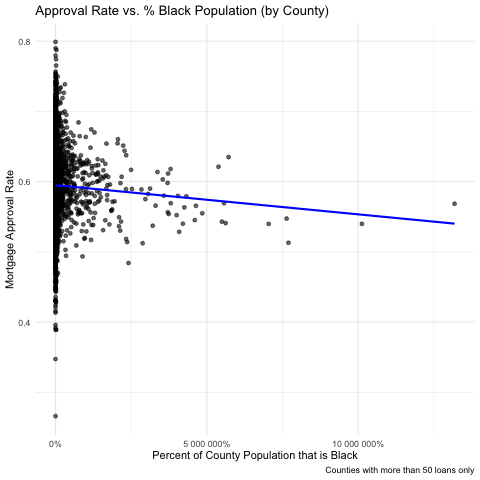

In [12]:
%%R 
df_clean <- df %>%
  mutate(
    approved = ifelse(action_taken == 1, 1, 0),
    post_georgefloyd = ifelse(activity_year >= 2020, 1, 0),
    county_code = as.character(as.integer(as.numeric(county_code)))
  ) %>%
  select(
    activity_year, county_code, lei, state_code, action_taken,
    loan_purpose, lien_status, occupancy_type, derived_dwelling_category,
    `applicant_race-1`, income, loan_amount, property_value,
    initially_payable_to_institution, `denial_reason-1`,
    ffiec_msa_md_median_family_income, employment_rate,
    median_household_income, income, post_georgefloyd, approved,
    population, black
  ) %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1
  )
county_plot_df <- df_clean %>%
  filter(!is.na(approved), !is.na(black), !is.na(population), population > 0) %>%
  group_by(county_code) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    pct_black = sum(black, na.rm = TRUE) / mean(population, na.rm = TRUE),
    total_loans = n()
  ) %>%
  filter(total_loans > 50)

ggplot(county_plot_df, aes(x = pct_black, y = approval_rate)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", color = "blue", se = FALSE) +
  scale_x_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Approval Rate vs. % Black Population (by County)",
    x = "Percent of County Population that is Black",
    y = "Mortgage Approval Rate",
    caption = "Counties with more than 50 loans only"
  ) +
  theme_minimal()


In [14]:
%%R
library(dplyr)

# Step 1: Clean the data
df_clean <- df %>%
  mutate(
    approved = ifelse(action_taken == 1, 1, 0),
    post_georgefloyd = ifelse(activity_year >= 2020, 1, 0),
    county_code = as.character(as.integer(as.numeric(county_code))),
    debt_to_income = loan_amount / income,
    black_applicant = ifelse(`applicant_race-1` == 3, 1, 0),
    post_dei_law = ifelse(activity_year >= 2022, 1, 0),
    anti_dei_state = ifelse(state_code %in% c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH"), 1, 0)
  ) %>%
  select(
    activity_year, county_code, lei, state_code, action_taken,
    loan_purpose, lien_status, occupancy_type, derived_dwelling_category,
    `applicant_race-1`, income, loan_amount, property_value,
    initially_payable_to_institution, `denial_reason-1`,
    ffiec_msa_md_median_family_income, employment_rate,
    median_household_income, income, post_georgefloyd, approved,
    population, debt_to_income, black_applicant, post_dei_law, anti_dei_state
  ) %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    !is.na(income), income > 0,
    !is.na(loan_amount), loan_amount > 0,
    !is.na(debt_to_income), is.finite(debt_to_income)
  )

# Step 2: Run the model
glm_dei <- glm(
  approved ~ post_dei_law * anti_dei_state + black_applicant + income + loan_amount + debt_to_income,
  data = df_clean,
  family = binomial()
)

# Step 3: View summary
summary(glm_dei)



Call:
glm(formula = approved ~ post_dei_law * anti_dei_state + black_applicant + 
    income + loan_amount + debt_to_income, family = binomial(), 
    data = df_clean)

Coefficients:
                              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)                  7.721e-01  7.799e-04  989.986   <2e-16 ***
post_dei_law                -5.419e-02  8.797e-04  -61.604   <2e-16 ***
anti_dei_state               6.719e-02  1.090e-03   61.668   <2e-16 ***
black_applicant             -2.529e-01  1.234e-03 -204.922   <2e-16 ***
income                      -6.200e-05  4.032e-07 -153.749   <2e-16 ***
loan_amount                  3.976e-08  1.323e-09   30.043   <2e-16 ***
debt_to_income              -3.312e-05  1.607e-07 -206.122   <2e-16 ***
post_dei_law:anti_dei_state  1.847e-02  2.000e-03    9.233   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 44792594  on 34768149  

In addition: Warning message:
glm.fit: fitted probabilities numerically 0 or 1 occurred 


In [52]:
%%R
library(dplyr)
library(fixest)

# Step 1: Clean and filter base data
df_clean <- df %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    `applicant_race-1` %in% c(1, 3)  # Keep only Black and White applicants
  ) %>%
  mutate(
    approved = ifelse(action_taken == 1, 1, 0),
    post_dei_law = ifelse(activity_year >= 2022, 1, 0),
    anti_dei_state = ifelse(state_code %in% c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH"), 1, 0),
    county_code = as.character(as.integer(as.numeric(county_code))),
    black_applicant = ifelse(`applicant_race-1` == 3, 1, 0),
    debt_to_income = loan_amount / income
  ) %>%
  filter(
    !is.na(income), income > 0,
    !is.na(loan_amount), loan_amount > 0,
    is.finite(debt_to_income)
  )

# Step 2: Aggregate to approval rates by year / county / LEI
approval_rates_df <- df_clean %>%
  group_by(activity_year, county_code, lei, state_code, `applicant_race-1`, post_dei_law, anti_dei_state) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    income = mean(income, na.rm = TRUE),
    loan_amount = mean(loan_amount, na.rm = TRUE),
    debt_to_income = mean(debt_to_income, na.rm = TRUE),
    .groups = "drop"
  )


In [53]:
%%R
df_black <- approval_rates_df %>% filter(`applicant_race-1` == 3)

fe_model_black <- feols(
  approval_rate ~ post_dei_law * anti_dei_state * + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_black
)

summary(fe_model_black)


OLS estimation, Dep. Var.: approval_rate
Observations: 421,542
Fixed-effects: county_code: 2,974,  activity_year: 6,  lei: 4,748
Standard-errors: Clustered (county_code) 
                                 Estimate   Std. Error   t value   Pr(>|t|)    
anti_dei_state               0.1867858651 4.329356e-02   4.31440 1.6525e-05 ***
income                      -0.0000025617 2.145300e-07 -11.94054  < 2.2e-16 ***
loan_amount                  0.0000000100 4.100000e-09   2.44178 1.4673e-02 *  
debt_to_income              -0.0000005522 2.258700e-07  -2.44475 1.4553e-02 *  
post_dei_law:anti_dei_state -0.0062137699 3.514571e-03  -1.76800 7.7163e-02 .  
... 1 variable was removed because of collinearity (post_dei_law)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.361376     Adj. R2: 0.133805
                 Within R2: 6.771e-4


NOTE: 7,914 observations removed because of NA values (Fixed-effects: 7,914).
The variable 'post_dei_law' has been removed because of collinearity (see $collin.var).


In [55]:
%%R
df_white <- approval_rates_df %>% filter(`applicant_race-1` == 1)

fe_model_white <- feols(
  approval_rate ~ post_dei_law * anti_dei_state + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_white
)

summary(fe_model_white)


OLS estimation, Dep. Var.: approval_rate
Observations: 128,425
Fixed-effects: county_code: 3,022,  activity_year: 6,  lei: 3,616
Standard-errors: Clustered (county_code) 
                                 Estimate   Std. Error   t value   Pr(>|t|)    
anti_dei_state               0.0989241837 0.1249302158  0.791836 0.42851875    
income                      -0.0000000431 0.0000000116 -3.698579 0.00022067 ***
loan_amount                  0.0000000121 0.0000000133  0.912725 0.36146018    
debt_to_income              -0.0000017033 0.0000004743 -3.591144 0.00033447 ***
post_dei_law:anti_dei_state  0.0023324270 0.0058213880  0.400665 0.68869503    
... 1 variable was removed because of collinearity (post_dei_law)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.389845     Adj. R2: 0.120971
                 Within R2: 8.424e-4


NOTE: 2,616 observations removed because of NA values (Fixed-effects: 2,616).
The variable 'post_dei_law' has been removed because of collinearity (see $collin.var).


In [32]:
%%R
library(fixest)
library(dplyr)

# Step 1: Ensure your data is prepped as before
df_clean <- df %>%
  mutate(
    approved = ifelse(action_taken == 1, 1, 0),
    post_dei_law = ifelse(activity_year >= 2022, 1, 0),
    anti_dei_state = ifelse(state_code %in% c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH"), 1, 0),
    black_applicant = ifelse(`applicant_race-1` == 3, 1, 0),
    debt_to_income = loan_amount / income
  ) %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    !is.na(income), income > 0,
    !is.na(loan_amount), loan_amount > 0,
    is.finite(debt_to_income)
  )

# Step 2: Run logistic regression with fixed effects + interaction
model <- feglm(
  approved ~ black_applicant * post_dei_law * anti_dei_state + income + loan_amount + debt_to_income | 
    county_code + activity_year + lei,
  data = df_clean,
  family = "binomial",
  cluster = "lei"
)

# Step 3: Review output
summary(model)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 33,562,649
Fixed-effects: county_code: 3,224,  activity_year: 6,  lei: 5,696
Standard-errors: Clustered (lei) 
                                                Estimate   Std. Error
black_applicant                             -0.304335051 0.0195534293
anti_dei_state                               0.879585666 0.2059816567
income                                      -0.000031947 0.0000157315
loan_amount                                  0.000000237 0.0000000683
debt_to_income                              -0.000052195 0.0000166371
black_applicant:post_dei_law                 0.000325206 0.0203154752
black_applicant:anti_dei_state               0.028073042 0.0180353247
post_dei_law:anti_dei_state                 -0.015215778 0.0142610708
black_applicant:post_dei_law:anti_dei_state -0.025587222 0.0170988291
                                               z value   Pr(>|z|)    
black_applicant                             -15.56

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: The GLM algorithm did not converge, the results are not reliable. (no convergence: Maximum number of iterations reached) 



NOTES: 1,193,089 observations removed because of NA values (RHS: 4,374, Fixed-effects: 1,188,844).
       14/0/343 fixed-effects (16,786 observations) removed because of only 0 (or only 1) outcomes.
The variable 'post_dei_law' has been removed because of collinearity (see $collin.var).
In addition: Warning message:
Absence of convergence: Maximum number of iterations reached (25). Final deviance: 37,918,251.0. 


In [51]:
%%R
df_black <- approval_rates_df %>% filter(`applicant_race-1` == 3)

fe_model_black <- feols(
  approval_rate ~ post_dei_law * anti_dei_state + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_black
)

summary(fe_model_black)


OLS estimation, Dep. Var.: approval_rate
Observations: 421,542
Fixed-effects: county_code: 2,974,  activity_year: 6,  lei: 4,748
Standard-errors: Clustered (county_code) 
                                 Estimate   Std. Error   t value   Pr(>|t|)    
anti_dei_state               0.1867858651 4.329356e-02   4.31440 1.6525e-05 ***
income                      -0.0000025617 2.145300e-07 -11.94054  < 2.2e-16 ***
loan_amount                  0.0000000100 4.100000e-09   2.44178 1.4673e-02 *  
debt_to_income              -0.0000005522 2.258700e-07  -2.44475 1.4553e-02 *  
post_dei_law:anti_dei_state -0.0062137699 3.514571e-03  -1.76800 7.7163e-02 .  
... 1 variable was removed because of collinearity (post_dei_law)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.361376     Adj. R2: 0.133805
                 Within R2: 6.771e-4


NOTE: 7,914 observations removed because of NA values (Fixed-effects: 7,914).
The variable 'post_dei_law' has been removed because of collinearity (see $collin.var).


In [45]:
%%R
library(dplyr)
library(fixest)

# Group by key categories and calculate approval rate
approval_rates_df <- df_clean %>%
  group_by(county_code, lei, activity_year, black_applicant, post_dei_law, anti_dei_state) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),  # <- this becomes your new outcome
    income = mean(income, na.rm = TRUE),
    loan_amount = mean(loan_amount, na.rm = TRUE),
    debt_to_income = mean(debt_to_income, na.rm = TRUE),
    total_loans = n(),
    .groups = "drop"
  )

approval_rates_df %>% head()



# A tibble: 6 × 11
  county_code lei      activity_year black_applicant post_dei_law anti_dei_state
  <chr>       <chr>            <dbl>           <dbl>        <dbl>          <dbl>
1 10001       03D0JEW…          2018               0            0              0
2 10001       03D0JEW…          2018               1            0              0
3 10001       03D0JEW…          2019               0            0              0
4 10001       03D0JEW…          2019               1            0              0
5 10001       03D0JEW…          2020               0            0              0
6 10001       03D0JEW…          2021               0            0              0
# ℹ 5 more variables: approval_rate <dbl>, income <dbl>, loan_amount <dbl>,
#   debt_to_income <dbl>, total_loans <int>


In [56]:
%%R 
approval_rates_df %>% head(n=20)

# A tibble: 20 × 11
   activity_year county_code lei      state_code `applicant_race-1` post_dei_law
           <dbl> <chr>       <chr>    <chr>                   <dbl>        <dbl>
 1          2018 10001       03D0JEW… DE                          3            0
 2          2018 10001       213800Q… DE                          3            0
 3          2018 10001       213800X… DE                          3            0
 4          2018 10001       2549001… DE                          3            0
 5          2018 10001       2549007… DE                          3            0
 6          2018 10001       254900A… DE                          3            0
 7          2018 10001       254900E… DE                          3            0
 8          2018 10001       254900F… DE                          3            0
 9          2018 10001       254900V… DE                          3            0
10          2018 10001       254900Z… DE                          3            0
11      

In [ ]:
%%R
# Run fixed-effects linear model on approval rates
fe_model_rate <- feols(
  approval_rate ~ post_dei_law * anti_dei_state * black_applicant + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = approval_rates_df
)

summary(fe_model_rate)

In [49]:
%%R
# Filter Black applicants only
df_black <- approval_rates_df %>%
  filter(`applicant_race.1` == 3)

# Run model for Black applicants
fe_model_black <- feols(
  approval_rate ~ post_dei_law * anti_dei_state + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_black
)

summary(fe_model_black)


Error in `filter()`:
ℹ In argument: `applicant_race.1 == 3`.
Caused by error:
! object 'applicant_race.1' not found
Run `rlang::last_trace()` to see where the error occurred.

Error in filter(., applicant_race.1 == 3) : 
Caused by error:
! object 'applicant_race.1' not found


RInterpreterError: Failed to parse and evaluate line '# Filter Black applicants only\ndf_black <- approval_rates_df %>%\n  filter(`applicant_race.1` == 3)\n\n# Run model for Black applicants\nfe_model_black <- feols(\n  approval_rate ~ post_dei_law * anti_dei_state + income + loan_amount + debt_to_income |\n    county_code + activity_year + lei,\n  data = df_black\n)\n\nsummary(fe_model_black)\n'.
R error message: "Error in filter(., applicant_race.1 == 3) : \nCaused by error:\n! object 'applicant_race.1' not found"

In [ ]:
## linear regression of black approval rates vs attribute of counties (black versus white) 
##fix the logical problem in the approval_rates_df (black and white) 

In [39]:
%%R
df_with_prediction <- approval_rates_df %>% 
    na.omit %>% 
    mutate (
        prediction=predict(fe_model_rate),
        residuals=resid(fe_model_rate),
        residuals_z=scale(residuals)
        
    )%>%
    arrange(residuals)
write.csv(df_with_prediction, 'df_with_prediction.csv')


In [41]:
import pandas as pd 
df = pd.read_csv('df_with_prediction.csv')
df

,Unnamed: 0,county_code,activity_year,lei,black_applicant,post_dei_law,anti_dei_state,approval_rate,income,loan_amount,debt_to_income,total_loans,prediction,residuals,residuals_z
0,1,12103,2019,549300GDJSUYPH6UC416,0,0,1,0.000000,2.190000e+02,1.106255e+09,5.051393e+06,1,4.629188,-4.629188,-13.707539
1,2,48465,2021,549300SXISSKGPHW5702,0,0,0,0.000000,1.190000e+02,7.019750e+08,5.898950e+06,1,2.067916,-2.067916,-6.123327
2,3,47189,2019,549300DMI3W6YLDVSK93,0,0,1,0.000000,4.200000e+02,2.800050e+08,6.666786e+05,1,1.854348,-1.854348,-5.490929
3,4,37147,2019,54930008MKP7T81OVK54,1,0,1,0.000000,3.500000e+01,1.350000e+05,3.857143e+03,1,1.108791,-1.108791,-3.283251
4,5,48085,2018,549300Q02LGIN9AXKP98,1,0,0,0.000000,5.000000e+02,9.800500e+07,1.960100e+05,1,1.030847,-1.030847,-3.052452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202861,2202862,48229,2018,7H6GLXDRUGQFU57RNE97,1,0,0,1.000000,8.700000e+01,2.350000e+05,2.701149e+03,1,-0.056376,1.056376,3.128046
2202862,2202863,8023,2019,549300GQDT484LGI9C04,0,0,0,1.000000,1.740000e+02,3.750000e+05,2.155172e+03,1,-0.063089,1.063089,3.147923
2202863,2202864,12021,2022,549300PTX8QF0BPQ5U19,0,1,1,1.000000,1.000000e+00,7.150000e+05,7.150000e+05,1,-0.093770,1.093770,3.238775
2202864,2202865,12086,2018,254900HA4DQWAE0W3342,0,0,0,1.000000,6.100000e+01,9.500000e+04,1.557377e+03,1,-0.111462,1.111462,3.291162


In [31]:
%%R
library(dplyr)

# Aggregate approval rate by county-year-lei-race group
approval_rates_df <- df_clean %>%
  group_by(county_code, activity_year, lei, black_applicant, post_dei_law, anti_dei_state) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    income = mean(income, na.rm = TRUE),
    loan_amount = mean(loan_amount, na.rm = TRUE),
    debt_to_income = mean(debt_to_income, na.rm = TRUE),
    .groups = "drop"
  )
library(fixest)

fe_model_rate <- feols(
  approval_rate ~ post_dei_law * anti_dei_state * black_applicant + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = approval_rates_df
)

summary(fe_model_rate)


OLS estimation, Dep. Var.: approval_rate
Observations: 2,202,866
Fixed-effects: county_code: 3,238,  activity_year: 6,  lei: 6,039
Standard-errors: Clustered (county_code) 
                                                 Estimate   Std. Error
anti_dei_state                               2.110154e-01 1.396455e-02
black_applicant                             -4.520454e-02 1.321707e-03
income                                      -9.716000e-08 7.627000e-08
loan_amount                                  4.740000e-09 2.720000e-09
debt_to_income                              -2.711300e-07 1.478800e-07
post_dei_law:anti_dei_state                 -1.363973e-03 1.583328e-03
post_dei_law:black_applicant                -1.263678e-02 1.567564e-03
anti_dei_state:black_applicant               3.104253e-03 2.983363e-03
post_dei_law:anti_dei_state:black_applicant -5.318190e-03 3.577112e-03
                                               t value   Pr(>|t|)    
anti_dei_state                               15

NOTE: 14,602 observations removed because of NA values (Fixed-effects: 14,602).
The variable 'post_dei_law' has been removed because of collinearity (see $collin.var).


In [15]:
%%R
feglm(
  approved ~ post_dei_law * anti_dei_state + black_applicant + income + loan_amount + debt_to_income |
    lei + county_code + activity_year,
  family = "logit",
  data = df_clean
)


GLM estimation, family = binomial(link = "logit"), Dep. Var.: approved
Observations: 33,562,649
Fixed-effects: lei: 5,696,  county_code: 3,224,  activity_year: 6
Standard-errors: Clustered (lei) 
                                Estimate   Std. Error   z value   Pr(>|z|)    
anti_dei_state               0.881580998 0.2059762130   4.28001 1.8688e-05 ***
black_applicant             -0.300514154 0.0185386238 -16.21017  < 2.2e-16 ***
income                      -0.000031948 0.0000157301  -2.03098 4.2257e-02 *  
loan_amount                  0.000000237 0.0000000683   3.47434 5.1212e-04 ***
debt_to_income              -0.000052189 0.0000166354  -3.13724 1.7055e-03 ** 
post_dei_law:anti_dei_state -0.017296829 0.0136810133  -1.26429 2.0612e-01    
... 1 variable was removed because of collinearity (post_dei_law)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -18,959,148.1   Adj. Pseudo R2: 0.101347
           BIC:  38,073,043.4     Squared Cor.: 0.130117
# Ev

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: The GLM algorithm did not converge, the results are not reliable. (no convergence: Maximum number of iterations reached) 



NOTES: 1,193,089 observations removed because of NA values (RHS: 4,374, Fixed-effects: 1,188,844).
       343/14/0 fixed-effects (16,786 observations) removed because of only 0 (or only 1) outcomes.
The variable 'post_dei_law' has been removed because of collinearity (see $collin.var).
In addition: Warning message:
Absence of convergence: Maximum number of iterations reached (25). Final deviance: 37,918,296.1. 


In [16]:
%%R
# Logistic regression with fixed effects, OLD RUN! 
fe_model <- feglm(
  approved ~ post_dei_law * anti_dei_state * black_applicant + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_clean,
  family = binomial()
)

summary(fe_model)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 33,562,649
Fixed-effects: county_code: 3,224,  activity_year: 6,  lei: 5,696
Standard-errors: Clustered (county_code) 
                                                Estimate   Std. Error
anti_dei_state                               0.879585666 0.0981754538
black_applicant                             -0.304335051 0.0112809252
income                                      -0.000031947 0.0000058244
loan_amount                                  0.000000237 0.0000000149
debt_to_income                              -0.000052195 0.0000018966
post_dei_law:anti_dei_state                 -0.015215778 0.0095748756
post_dei_law:black_applicant                 0.000325206 0.0062248482
anti_dei_state:black_applicant               0.028073042 0.0200215079
post_dei_law:anti_dei_state:black_applicant -0.025587222 0.0148626916
                                               z value   Pr(>|z|)    
anti_dei_state                            

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: The GLM algorithm did not converge, the results are not reliable. (no convergence: Maximum number of iterations reached) 



NOTES: 1,193,089 observations removed because of NA values (RHS: 4,374, Fixed-effects: 1,188,844).
       14/0/343 fixed-effects (16,786 observations) removed because of only 0 (or only 1) outcomes.
The variable 'post_dei_law' has been removed because of collinearity (see $collin.var).
In addition: Warning message:
Absence of convergence: Maximum number of iterations reached (25). Final deviance: 37,918,251.0. 


In [25]:
%%R
# Add More Predictive Variables to postGeorge Floyd model 
fe_model_controls <- feols(
  approved ~ post_georgefloyd * black_applicant +
    income + loan_amount + debt_to_income + property_value + ffiec_msa_md_median_family_income +
    lien_status + occupancy_type + employment_rate |
    county_code + activity_year + lei,
  data = df_clean
)
summary(fe_model_controls)


Error in feols(approved ~ post_georgefloyd * black_applicant + income +  : 
  Evaluation of the right-hand-side of the formula raises an error: 
  vector memory limit of 128.0 Gb reached, see mem.maxVSize()


RInterpreterError: Failed to parse and evaluate line '# Add More Predictive Variables to postGeorge Floyd model \nfe_model_controls <- feols(\n  approved ~ post_georgefloyd * black_applicant +\n    income + loan_amount + debt_to_income + property_value + ffiec_msa_md_median_family_income +\n    lien_status + occupancy_type + employment_rate |\n    county_code + activity_year + lei,\n  data = df_clean\n)\nsummary(fe_model_controls)\n'.
R error message: 'Error in feols(approved ~ post_georgefloyd * black_applicant + income +  : \n  Evaluation of the right-hand-side of the formula raises an error: \n  vector memory limit of 128.0 Gb reached, see mem.maxVSize()'

In [26]:
%%R
#predicitve model predicted probability of loan approval for a specific person
feglm_model <- feglm(
  approved ~ black_applicant + income + loan_amount + debt_to_income + employment_rate |
    lei + county_code + activity_year,
  data = df_clean,
  family = "logit"
)


NOTES: 1,189,861 observations removed because of NA values (RHS: 1,189,861, Fixed-effects: 1,188,715).
       343/1/0 fixed-effects (16,758 observations) removed because of only 0 (or only 1) outcomes.
The variable 'employment_rate' has been removed because of collinearity (see $collin.var).
In addition: Warning message:
Absence of convergence: Maximum number of iterations reached (25). Final deviance: 37,917,495.4. 


In [27]:
%%R
#attempt to improve R squared 
fe_model <- feols(
  approved ~ post_georgefloyd * black_applicant +
    income + loan_amount + debt_to_income + property_value +
    lien_status + occupancy_type + ffiec_msa_md_median_family_income +
    employment_rate +
    black_applicant * income +
    black_applicant * loan_amount |
    county_code + activity_year + lei,
  data = df_clean
)

summary(fe_model)


Error in feols(approved ~ post_georgefloyd * black_applicant + income +  : 
  Evaluation of the right-hand-side of the formula raises an error: 
  vector memory limit of 128.0 Gb reached, see mem.maxVSize()


RInterpreterError: Failed to parse and evaluate line '#attempt to improve R squared \nfe_model <- feols(\n  approved ~ post_georgefloyd * black_applicant +\n    income + loan_amount + debt_to_income + property_value +\n    lien_status + occupancy_type + ffiec_msa_md_median_family_income +\n    employment_rate +\n    black_applicant * income +\n    black_applicant * loan_amount |\n    county_code + activity_year + lei,\n  data = df_clean\n)\n\nsummary(fe_model)\n'.
R error message: 'Error in feols(approved ~ post_georgefloyd * black_applicant + income +  : \n  Evaluation of the right-hand-side of the formula raises an error: \n  vector memory limit of 128.0 Gb reached, see mem.maxVSize()'

In [19]:
%%R
fe_model <- feglm(
  approved ~ post_dei_law * anti_dei_state * black_applicant + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_clean,
  family = "logit",
  control = list(maxit = 100, epsilon = 1e-8)
)

summary(fe_model)


GLM estimation, family = binomial(link = "logit"), Dep. Var.: approved
Observations: 33,562,649
Fixed-effects: county_code: 3,224,  activity_year: 6,  lei: 5,696
Standard-errors: Clustered (county_code) 
                                                Estimate   Std. Error
anti_dei_state                               0.879585666 0.0981754538
black_applicant                             -0.304335051 0.0112809252
income                                      -0.000031947 0.0000058244
loan_amount                                  0.000000237 0.0000000149
debt_to_income                              -0.000052195 0.0000018966
post_dei_law:anti_dei_state                 -0.015215778 0.0095748756
post_dei_law:black_applicant                 0.000325206 0.0062248482
anti_dei_state:black_applicant               0.028073042 0.0200215079
post_dei_law:anti_dei_state:black_applicant -0.025587222 0.0148626916
                                               z value   Pr(>|z|)    
anti_dei_state            

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: The GLM algorithm did not converge, the results are not reliable. (no convergence: Maximum number of iterations reached) 



NOTES: 1,188,715 observations removed because of NA values (Fixed-effects: 1,188,715).
       14/0/343 fixed-effects (16,786 observations) removed because of only 0 (or only 1) outcomes.
The variable 'post_dei_law' has been removed because of collinearity (see $collin.var).
In addition: Warning messages:
1: In fixest_env(fml = fml, data = data, family = famil...:
 feglm(fml = app...: control is not a valid argument for function feglm() 
2: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 37,918,251.0. 


In [30]:
%%R
library(dplyr)

# Group by example: county + year + Black status
approval_rates_df <- df_clean %>%
  group_by(county_code, activity_year, black_applicant) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    total_loans = n(),
    avg_income = mean(income, na.rm = TRUE),
    avg_dti = mean(debt_to_income, na.rm = TRUE),
    .groups = "drop"
  )
# Linear regression on approval rates (not binary anymore)
lm_model <- lm(
  approval_rate ~ black_applicant * activity_year + avg_income + avg_dti,
  data = approval_rates_df
)

summary(lm_model)




Call:
lm(formula = approval_rate ~ black_applicant * activity_year + 
    avg_income + avg_dti, data = approval_rates_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.69227 -0.05055  0.00879  0.05974  0.51211 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   -9.426e+00  1.439e+00  -6.551 5.78e-11 ***
black_applicant                1.466e+01  2.194e+00   6.682 2.39e-11 ***
activity_year                  5.002e-03  7.121e-04   7.025 2.18e-12 ***
avg_income                    -5.326e-06  1.900e-06  -2.804 0.005049 ** 
avg_dti                       -8.718e-07  2.292e-07  -3.803 0.000143 ***
black_applicant:activity_year -7.277e-03  1.086e-03  -6.703 2.08e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.169 on 34028 degrees of freedom
Multiple R-squared:  0.01966,	Adjusted R-squared:  0.01952 
F-statistic: 136.5 on 5 and 34028 DF,  p-value: < 2.2e-16



In [29]:
%%R
library(fixest)

# Run logistic regression with fixed effects
feglm_dei <- feglm(
  approved ~ post_dei_law * anti_dei_state + black_applicant + income + loan_amount + debt_to_income |
    lei + county_code + interaction(county_code, activity_year),
  family = binomial(),
  data = df_clean
)

# View the summary
summary(feglm_dei)


NOTES: 1,188,715 observations removed because of NA values (Fixed-effects: 1,188,715).
       343/18/132 fixed-effects (17,093 observations) removed because of only 0 (or only 1) outcomes.

Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  cpp_demean: User interrupt.


RInterpreterError: Failed to parse and evaluate line 'library(fixest)\n\n# Run logistic regression with fixed effects\nfeglm_dei <- feglm(\n  approved ~ post_dei_law * anti_dei_state + black_applicant + income + loan_amount + debt_to_income |\n    lei + county_code + interaction(county_code, activity_year),\n  family = binomial(),\n  data = df_clean\n)\n\n# View the summary\nsummary(feglm_dei)\n'.
R error message: 'Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : \n  cpp_demean: User interrupt.'
R stdout:
NOTES: 1,188,715 observations removed because of NA values (Fixed-effects: 1,188,715).
       343/18/132 fixed-effects (17,093 observations) removed because of only 0 (or only 1) outcomes.

Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  cpp_demean: User interrupt.

In [21]:
%%R
library(dplyr)
library(ggplot2)

# Build prediction grid across all key groups
predict_df <- expand.grid(
  post_dei_law = c(0, 1),
  anti_dei_state = c(0, 1),
  black_applicant = c(0, 1),
  income = mean(df_clean$income, na.rm = TRUE),
  loan_amount = mean(df_clean$loan_amount, na.rm = TRUE),
  debt_to_income = mean(df_clean$debt_to_income, na.rm = TRUE),
  county_code = NA, activity_year = NA, lei = NA
)

# Predict using model (ignore fixed effects)
predict_df$predicted_prob <- predict(
  fe_model,
  newdata = predict_df,
  type = "response",
  fixef = FALSE
)

# Label for clarity
predict_df <- predict_df %>%
  mutate(
    Race = ifelse(black_applicant == 1, "Black Applicant", "Non-Black Applicant"),
    DEI_State = ifelse(anti_dei_state == 1, "Anti-DEI State", "Non-DEI State"),
    Period = ifelse(post_dei_law == 1, "After DEI Law", "Before DEI Law")
  )


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 8 rows containing missing values or values outside the scale range
(`geom_col()`). 



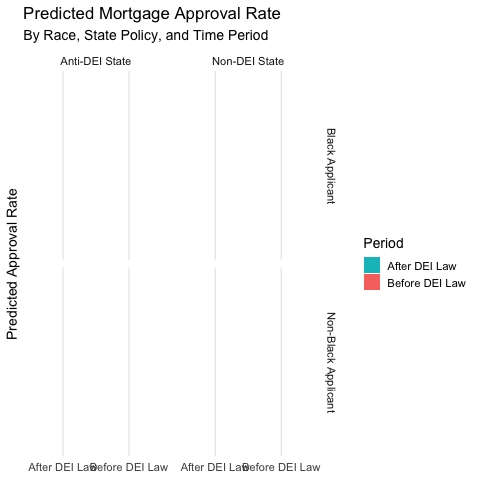

In [22]:
%%R
# Facet by DEI State and Race
ggplot(predict_df, aes(x = Period, y = predicted_prob, fill = Period)) +
  geom_col(width = 0.6, position = "dodge") +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  facet_grid(Race ~ DEI_State) +
  labs(
    title = "Predicted Mortgage Approval Rate",
    subtitle = "By Race, State Policy, and Time Period",
    y = "Predicted Approval Rate",
    x = NULL
  ) +
  scale_fill_manual(values = c("Before DEI Law" = "#f8766d", "After DEI Law" = "#00bfc4")) +
  theme_minimal(base_size = 14)


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 4 rows containing missing values or values outside the scale range
(`geom_col()`). 



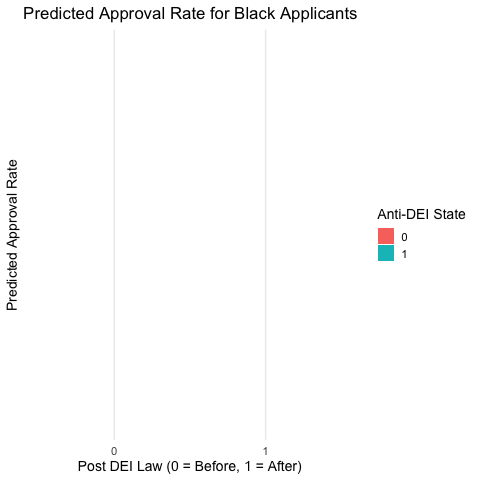

In [20]:
%%R
library(dplyr)
library(ggplot2)

# Create a new dataset for prediction
predict_df <- expand.grid(
  post_dei_law = c(0, 1),
  anti_dei_state = c(0, 1),
  black_applicant = 1,
  income = mean(df_clean$income, na.rm = TRUE),
  loan_amount = mean(df_clean$loan_amount, na.rm = TRUE),
  debt_to_income = mean(df_clean$debt_to_income, na.rm = TRUE),
  county_code = NA,
  activity_year = NA,
  lei = NA
)

# Predict approval probabilities
predict_df$predicted_prob <- predict(fe_model, newdata = predict_df, type = "response", fixef = FALSE)


# Plot
ggplot(predict_df, aes(x = factor(post_dei_law), y = predicted_prob, fill = factor(anti_dei_state))) +
  geom_col(position = "dodge", width = 0.6) +
  scale_fill_manual(values = c("#f8766d", "#00bfc4")) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Predicted Approval Rate for Black Applicants",
    x = "Post DEI Law (0 = Before, 1 = After)",
    y = "Predicted Approval Rate",
    fill = "Anti-DEI State"
  ) +
  theme_minimal(base_size = 14)



In [18]:
%%R
library(fixest)
library(dplyr)

# Step 1: Prepare the data with log transforms to help convergence
df_clean <- df_clean %>%
  mutate(
    log_income = log(income),
    log_loan_amount = log(loan_amount),
    debt_to_income = loan_amount / income
  ) %>%
  filter(
    !is.na(approved), !is.na(post_dei_law), !is.na(anti_dei_state),
    !is.na(black_applicant), !is.na(log_income), is.finite(log_income),
    !is.na(log_loan_amount), is.finite(log_loan_amount),
    !is.na(debt_to_income), is.finite(debt_to_income)
  )

# Step 2: Run the fixed-effects logistic regression with extended convergence settings
feglm_model <- feglm(
  approved ~ post_dei_law * anti_dei_state + black_applicant +
    log_income + log_loan_amount + debt_to_income |
    lei + county_code + activity_year,
  family = "logit",
  data = df_clean,
  control = list(maxit = 100, epsilon = 1e-8)  # Increase max iterations, tighten convergence
)

# Step 3: View results
summary(feglm_model)


GLM estimation, family = binomial(link = "logit"), Dep. Var.: approved
Observations: 33,562,649
Fixed-effects: lei: 5,696,  county_code: 3,224,  activity_year: 6
Standard-errors: Clustered (lei) 
                             Estimate Std. Error    z value   Pr(>|z|)    
anti_dei_state               0.889406   0.203790   4.364326 1.2752e-05 ***
black_applicant             -0.281030   0.019064 -14.741460  < 2.2e-16 ***
log_income                   0.069978   0.073615   0.950587 3.4181e-01    
log_loan_amount              0.117940   0.051875   2.273544 2.2993e-02 *  
debt_to_income              -0.000048   0.000032  -1.512868 1.3031e-01    
post_dei_law:anti_dei_state -0.021293   0.013394  -1.589738 1.1189e-01    
... 1 variable was removed because of collinearity (post_dei_law)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -18,937,145.0   Adj. Pseudo R2: 0.102389
           BIC:  38,029,037.2     Squared Cor.: 0.131557
# Evaluations: lhs: 25 -- no con

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: The GLM algorithm did not converge, the results are not reliable. (no convergence: Maximum number of iterations reached) 



NOTES: 1,188,715 observations removed because of NA values (Fixed-effects: 1,188,715).
       343/14/0 fixed-effects (16,786 observations) removed because of only 0 (or only 1) outcomes.
The variable 'post_dei_law' has been removed because of collinearity (see $collin.var).
In addition: Warning messages:
1: In fixest_env(fml = fml, data = data, family = famil...:
 feglm(fml = app...: control is not a valid argument for function feglm() 
2: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 37,874,289.9. 


In [ ]:
%%R
library(dplyr)

# Step 1: Filter to Black applicants only
df_black <- df_dei_clean %>%
  filter(black_applicant == 1)

# Step 2: Run logistic regression (DEI impact among Black applicants)
glm_black_dei <- glm(
  approved ~ post_dei_law * anti_dei_state + income + loan_amount + debt_to_income,
  data = df_black,
  family = binomial()
)

# Step 3: Show results
summary(glm_black_dei)


In [ ]:
#Anti-DEI states 

In [ ]:
%%R
dei_states <- c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH")

df_clean <- df %>%
  mutate(
    anti_dei_state = ifelse(state_code %in% dei_states, 1, 0)
  )


In [ ]:
# %%R
# df_clean <- df %>%
#   mutate(post_dei_law = ifelse(activity_year >= 2022, 1, 0))


In [ ]:
# %%R
# df_clean <- df %>%
#   mutate(debt_to_income = loan_amount / income)
